In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import random as rd
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)


df = pd.read_csv('iris.data', header=None, sep=',')
df.columns = ["sepal_length", "sepal_width", "petal_length", "petal_width","class"] 
class_labels = df.pop("class")
# Standardization of data
# df = (df - df.mean(axis=0))
df.shape


In [53]:
# 4.1 Create a new data set with two features by computing the ratio of raw features x = (x1, x2) where 
# x1 = (sepal length/sepal width) and x2 = (petal length/petal width)) and plot the data to observe the clusters 
# in data by yourself (use class label to color the data points for better illustration of clusters)

new_df = pd.DataFrame()
new_df["x1"] = df["sepal_length"]/df["sepal_width"]
new_df["x2"] = df["petal_length"]/df["petal_width"]


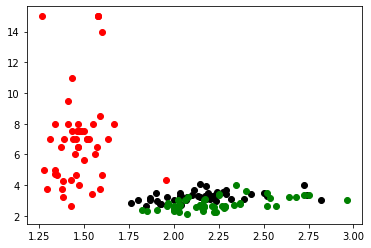

In [54]:

frames = []
for c in np.unique(class_labels):
    frames.append(new_df[class_labels.isin([c])])

colors = ["red","black","green"]
for i,f in enumerate(frames):
    plt.scatter(frames[i]["x1"] , frames[i]["x2"] , color = colors[i])
plt.show()

In [64]:
# 4.2 Implement the k-means++ algorithm. Submit the source code (documented!) of your implementation

# Solution:
# We begin by choosing a random point from the data.
# Then, we choose the next point such that is more probable to lie at a large distance from the first point. 
# We do so by sampling a point from a probability distribution that is proportional to the squared distance of a point
# from the first center.
# The remaining points are generated by a probability distribution that is proportional to the squared distance of 
# each point from its closest center. So, a point having a large distance from its closest center is more likely 
# to be sampled.

# def dist(data, centers):
#     distance = np.sum((np.array(centers) - data[:, None, :])**2, axis = 2)
#     return distance
# def get_centroids(X, k, pdf_method = True):
#     '''Initialize one point at random.
#     loop for k - 1 iterations:
#         Next, calculate for each point the distance of the point from its nearest center. Sample a point with a 
#         probability proportional to the square of the distance of the point from its nearest center.'''
#     centers = []
#     X = np.array(X)
    
#     # Sample the first point
#     initial_index = np.random.choice(range(X.shape[0]), )
#     centers.append(X[initial_index, :].tolist())
    
#     # Loop and select the remaining points
#     for i in range(k - 1):
#         distance = dist(X, np.array(centers))
        
#         if i == 0:
#             pdf = distance/np.sum(distance)
#             centroid_new = X[np.random.choice(range(X.shape[0]), replace = False, p = pdf.flatten())]
#         else:
#             # Calculate the distance of each point from its nearest centroid
#             dist_min = np.min(distance, axis = 1)
#             if pdf_method == True:
#                             pdf = dist_min/np.sum(dist_min)
#             # Sample one point from the given distribution
#                             centroid_new = X[np.random.choice(range(X.shape[0]), replace = False, p = pdf)]
#             else:
#                 index_max = np.argmax(dist_min, axis = 0)
#                 centroid_new = X[index_max, :]
#         centers.append(centroid_new.tolist())
        
#     return np.array(centers)



def k_means_fit(X,centroids, n = 5,iterations=999999,strict = False):
    #get a copy of the original data
    X_data = X.copy()
    X_columns = X.columns.values
    diff = 1
    j=0

    while(diff!=0 and j!=iterations):
        #creating a copy of the original dataframe
        i=1
        #iterate over each centroid point 
        for index1,row_c in centroids.iterrows():
            ED=[]
            #iterate over each data point
            for index2,row_d in X_data.iterrows():
                #calculate distance between current point and centroid
                d=np.sum((row_c.to_numpy() - row_d[X_columns].to_numpy())**2)
                #append distance in a list 'ED'
                ED.append(d)
            #append distace for a centroid in original data frame
            X[i]=ED
            i=i+1

        C=[]
        for index,row in X.iterrows():

            #get distance from centroid of current data point
            min_dist=row[1]
            pos=1

            #loop to locate the closest centroid to current point
            for i in range(n):

                #if current distance is greater than that of other centroids
                if row[i+1] < min_dist:

                    #the smaller distanc becomes the minimum distance 
                    min_dist = row[i+1]
                    pos=i+1
            C.append(pos)

        #assigning the closest cluster to each data point
        X["Cluster"]=C
#         print(X.head())
        #grouping each cluster by their mean value to create new centroids
        centroids_new = X.groupby(["Cluster"]).mean()[X_columns]
#         print("New Cenrtoids:",centroids_new)
#         print("Old Cenrtoids:",centroids)
        if j == 0:
            diff=1
            j=j+1

        else:
            #check if there is a difference between old and new centroids
            if(not strict):
                diff = ((centroids_new - centroids).sum()**2).sum()
            j+=1
        centroids = X.groupby(["Cluster"]).mean()[X_columns]
    return X, centroids

def get_centroids(X,columns,k = 3):
    centroids = X.sample()
    i = 1
    dist = []
    while i != k:
        max_dist = [0 for i in range(X.shape[0])]
        #go through the centroids
        for index, row in centroids.iterrows():
            #calculate distance of every centroid with every other data point 
            d = np.sum((X[columns] - row[columns])**2,axis=1)
            #check which centroid has a max distance with another point
            if max(d) > max(max_dist):
                max_dist = d    
        X["dist"] = max_dist
        idx = X['dist'].idxmax()
        max_coor = pd.DataFrame(X.iloc[idx][columns]).T
        centroids = pd.concat([centroids,max_coor])
        X = X.drop(idx)
        i+=1
    return centroids

In [65]:
# Cluster the modified Iris dataset with the two features explained above. Run your algorithm 50 times over the data 
# with different values of clusters k = 1, 2, . . . , 5 and plot the accuracies (x and y axes should be the number 
# of clusters and the clustering objective 

from sklearn.metrics import davies_bouldin_score

k_values = [1,2,3,4,5]
column = new_df.columns
clustered_results,centroid_results,dbi = [],[],[]
color=['brown','blue','green','cyan','pink']
for k in k_values:
    centroids = pd.DataFrame(get_centroids(new_df.copy(),column,k))
    clustered_x,centroids = k_means_fit(new_df.copy(),centroids,k,50)
    if(k!=1):
        dbi.append(davies_bouldin_score(new_df, clustered_x['Cluster']))




<class 'numpy.ndarray'>
Iteration # 0
Iteration # 1
[1]
<class 'numpy.ndarray'>
Iteration # 0
Iteration # 1
[1 2]
For k =  2  DBI:  0.34024794906992745
<class 'numpy.ndarray'>
Iteration # 0
Iteration # 1
Iteration # 2
Iteration # 3
Iteration # 4
Iteration # 5
Iteration # 6
[1 2 3]
For k =  3  DBI:  0.2808442900569906
<class 'numpy.ndarray'>
Iteration # 0
Iteration # 1
Iteration # 2
Iteration # 3
Iteration # 4
Iteration # 5
Iteration # 6
Iteration # 7
Iteration # 8
Iteration # 9
Iteration # 10
Iteration # 11
Iteration # 12
Iteration # 13
Iteration # 14
[1 2 3 4]
For k =  4  DBI:  0.48712277868021836
<class 'numpy.ndarray'>
Iteration # 0
Iteration # 1
Iteration # 2
Iteration # 3
Iteration # 4
Iteration # 5
Iteration # 6
Iteration # 7
Iteration # 8
Iteration # 9
Iteration # 10
[1 2 3 4 5]
For k =  5  DBI:  0.5472261177214243


The Dunn index (DI) (introduced by J. C. Dunn in 1974), a metric for evaluating clustering algorithms, is an internal
evaluation scheme, where the result is based on the clustered data itself. Like all other such indices, the aim of 
this Dunn index to identify sets of clusters that are compact, with a small variance between members of the cluster, 
and well separated, where the means of different clusters are sufficiently far apart, as compared to the within 
cluster variance. 
Higher the Dunn index value, better is the clustering. The number of clusters that maximizes Dunn index is taken 
as the optimal number of clusters k


DB index :
The Davies–Bouldin index (DBI) (introduced by David L. Davies and Donald W. Bouldin in 1979), a metric for evaluating clustering algorithms, is an internal evaluation scheme, where the validation of how well the clustering has been done is made using quantities and features inherent to the dataset. 
Lower the DB index value, better is the clustering.






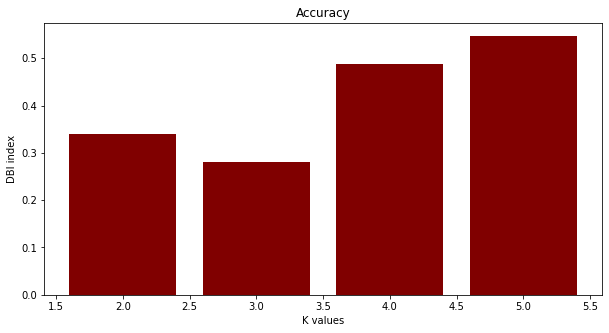

In [66]:
  
fig = plt.figure(figsize = (10, 5))
k_clusters = [i for i in range(2,len(dbi)+2)]
# creating the bar plot
plt.bar(k_clusters, dbi, color ='maroon')
 
plt.xlabel("K values")
plt.ylabel("DBI index")
plt.title("Accuracy")
plt.show()


Based on the above graph, k=3 has the least DBI index. Hence, we take k=3 to make our predictions.

<class 'numpy.ndarray'>
Iteration # 0
Iteration # 1
[1 2 3]
For k =  3  DBI:  0.7590271135748767
<class 'numpy.ndarray'>
Iteration # 0
Iteration # 1
Iteration # 2
[1 2 3]
For k =  3  DBI:  0.500989018057714
<class 'numpy.ndarray'>
Iteration # 0
Iteration # 1
Iteration # 2
Iteration # 3
[1 2 3]
For k =  3  DBI:  0.2569306928383744
<class 'numpy.ndarray'>
Iteration # 0
Iteration # 1
Iteration # 2
Iteration # 3
Iteration # 4
[1 2 3]
For k =  3  DBI:  0.2569306928383744
<class 'numpy.ndarray'>
Iteration # 0
Iteration # 1
Iteration # 2
Iteration # 3
Iteration # 4
Iteration # 5
[1 2 3]
For k =  3  DBI:  0.2808442900569906
<class 'numpy.ndarray'>
Iteration # 0
Iteration # 1
Iteration # 2
Iteration # 3
Iteration # 4
Iteration # 5
Iteration # 6
[1 2 3]
For k =  3  DBI:  0.2808442900569906
<class 'numpy.ndarray'>
Iteration # 0
Iteration # 1
Iteration # 2
Iteration # 3
Iteration # 4
Iteration # 5
Iteration # 6
Iteration # 7
[1 2 3]
For k =  3  DBI:  0.2808442900569906
<class 'numpy.ndarray'>
Iter

Iteration # 2
Iteration # 3
Iteration # 4
Iteration # 5
Iteration # 6
Iteration # 7
Iteration # 8
Iteration # 9
Iteration # 10
Iteration # 11
Iteration # 12
Iteration # 13
Iteration # 14
Iteration # 15
Iteration # 16
Iteration # 17
Iteration # 18
Iteration # 19
Iteration # 20
Iteration # 21
Iteration # 22
Iteration # 23
Iteration # 24
Iteration # 25
Iteration # 26
Iteration # 27
Iteration # 28
Iteration # 29
[1 2 3]
For k =  3  DBI:  0.2808442900569906
<class 'numpy.ndarray'>
Iteration # 0
Iteration # 1
Iteration # 2
Iteration # 3
Iteration # 4
Iteration # 5
Iteration # 6
Iteration # 7
Iteration # 8
Iteration # 9
Iteration # 10
Iteration # 11
Iteration # 12
Iteration # 13
Iteration # 14
Iteration # 15
Iteration # 16
Iteration # 17
Iteration # 18
Iteration # 19
Iteration # 20
Iteration # 21
Iteration # 22
Iteration # 23
Iteration # 24
Iteration # 25
Iteration # 26
Iteration # 27
Iteration # 28
Iteration # 29
Iteration # 30
[1 2 3]
For k =  3  DBI:  0.2808442900569906
<class 'numpy.ndarr

Iteration # 33
Iteration # 34
Iteration # 35
Iteration # 36
Iteration # 37
Iteration # 38
Iteration # 39
Iteration # 40
Iteration # 41
Iteration # 42
[1 2 3]
For k =  3  DBI:  0.2808442900569906
<class 'numpy.ndarray'>
Iteration # 0
Iteration # 1
Iteration # 2
Iteration # 3
Iteration # 4
Iteration # 5
Iteration # 6
Iteration # 7
Iteration # 8
Iteration # 9
Iteration # 10
Iteration # 11
Iteration # 12
Iteration # 13
Iteration # 14
Iteration # 15
Iteration # 16
Iteration # 17
Iteration # 18
Iteration # 19
Iteration # 20
Iteration # 21
Iteration # 22
Iteration # 23
Iteration # 24
Iteration # 25
Iteration # 26
Iteration # 27
Iteration # 28
Iteration # 29
Iteration # 30
Iteration # 31
Iteration # 32
Iteration # 33
Iteration # 34
Iteration # 35
Iteration # 36
Iteration # 37
Iteration # 38
Iteration # 39
Iteration # 40
Iteration # 41
Iteration # 42
Iteration # 43
[1 2 3]
For k =  3  DBI:  0.2808442900569906
<class 'numpy.ndarray'>
Iteration # 0
Iteration # 1
Iteration # 2
Iteration # 3
Iterat

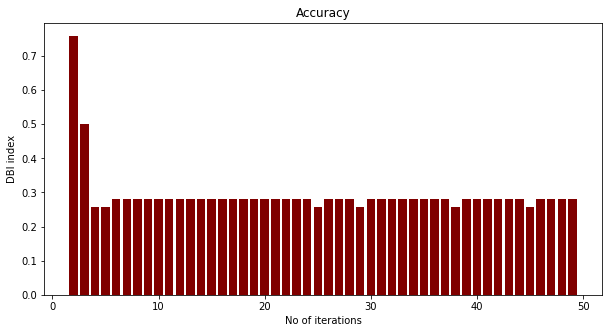

In [70]:
# Based on the above plot, decide the number of final clusters and justify your answer. For the chosen number of clusters,
# • Create a plot showing how the accuracy changes with the number of iterations. 


# Taking k = 3, since that has the best accuracy(i.e., lowest intra cluster distance and highest inter cluster distance)
#plot data

k = 3
dbi3 = []
for i in range(2,50):
    centroids = pd.DataFrame(get_centroids(new_df.copy(),column,k))
    clustered_x,centroids = k_means_fit(new_df.copy(),centroids,k,i,strict=True)
    print(np.unique(clustered_x["Cluster"]))
    if(k!=1):
        print("For k = ",k," DBI: ",davies_bouldin_score(new_df, clustered_x['Cluster']))
        dbi3.append(davies_bouldin_score(new_df, clustered_x['Cluster']))
    
fig = plt.figure(figsize = (10, 5))
k_clusters = [i for i in range(2,len(dbi3)+2)]
# creating the bar plot
plt.bar(k_clusters, dbi3, color ='maroon')
 
plt.xlabel("No of iterations")
plt.ylabel("DBI index")
plt.title("Accuracy")
plt.show()    







<class 'numpy.ndarray'>
Iteration # 0
Iteration # 1
Iteration # 2
Iteration # 3
Iteration # 4
Iteration # 5
Iteration # 6


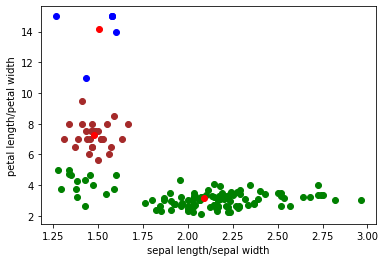

In [71]:
# • Create a plot with the data colored by assignment, and the cluster centers.

k = 3
centroids = pd.DataFrame(get_centroids(new_df.copy(),column,k))
clustered_x,centroids = k_means_fit(new_df.copy(),centroids,k,50)

plt.figure()
for i in range(k):
    cluster=clustered_x[clustered_x["Cluster"]==i+1]
    plt.scatter(cluster["x1"],cluster["x2"],c=color[i])

#plot centroids   
plt.scatter(centroids["x1"],centroids["x2"],c='red')
plt.xlabel('sepal length/sepal width')
plt.ylabel('petal length/petal width')
plt.show()